In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn

seaborn.set()
seaborn.set_style("ticks")
seaborn.set_context("poster")
from matplotlib import pyplot

In [12]:
def print_nonselectivity(title, data, marker_styles, curve_colors, curve_styles, curve_labels, yticks, leg_title, rand_base):
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.title(title , fontsize=25)
    plt.xlabel(r'Model Size Factor', fontsize=25)
    plt.ylabel(r'% Neurons With Selectivity < 0.05', fontsize=25)
    plt.xlim((0.245, 4.07))
    plt.ylim((-1, np.max(yticks)))
    plt.grid(True, which='both')
    plt.xscale('log')
    plt.xticks(size_factors, size_labels)
    plt.yticks(yticks)

    for curve_idx in range(np.shape(data)[0]):
        non_0_idx = (data[curve_idx,:] != -1)
        plt.plot(size_factors[non_0_idx], data[curve_idx,non_0_idx],
                 marker=marker_styles[curve_idx], markersize=12, color=curve_colors[curve_idx],
                 linestyle=curve_styles[curve_idx], linewidth=4)

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(25)

    leg = plt.legend(curve_labels, loc=(-0.68, 0.13), framealpha=0.8, fontsize=15, title=leg_title)
    leg.get_title().set_fontsize('15')
    plt.rc('xtick',labelsize=8)

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


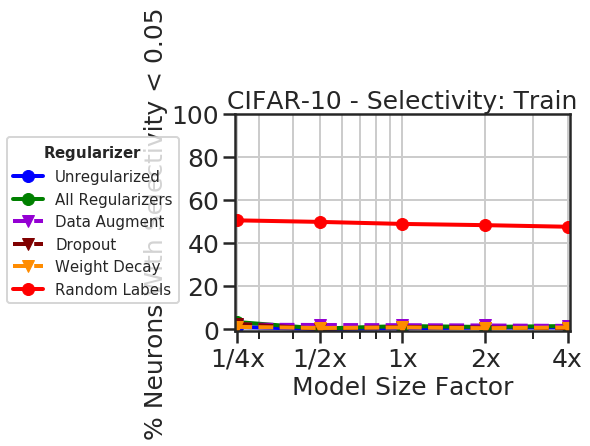

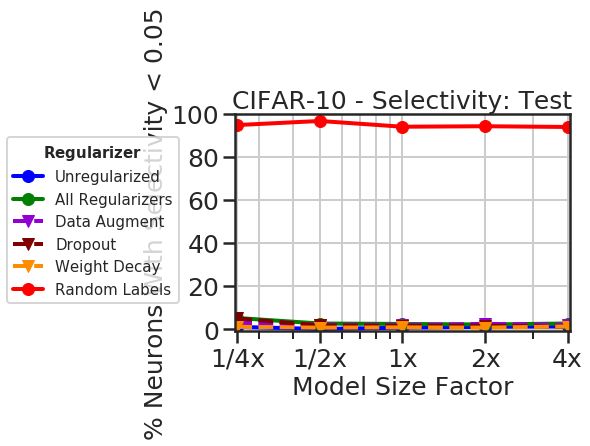

In [13]:

sys.path.append('../')
import experiments

curves = 6
curve_labels = ['Unregularized', 'All Regularizers', 'Data Augment', 'Dropout', 'Weight Decay', 'Random Labels']
curve_colors = ['blue', 'green', 'darkviolet', 'maroon', 'darkorange', 'red']
curve_styles = ['-', '-', '--', '--', '--', '-']
sizes = 5
marker_styles = ['o', 'o', 'v', 'v', 'v', 'o']
yticks = [0, 20, 40, 60, 80, 100]
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 3

results = np.zeros((curves, sizes))
results_test = np.zeros((curves, sizes))
# both are indexed [size_factor][nn_type][mean/lowererr/uppererr]
# we have to make sure to not be sketchy and state that these are averages between samplings and not nets

for ID in range(62, 92):
    opt = experiments.opt[ID]

    curve_idx = 0  # unregularized
    if opt.dataset.random_labels:
        curve_idx = 5  # random labels
    elif opt.hyper.augmentation and opt.hyper.drop_train < 1:
        curve_idx = 1  # all regularizers
    elif opt.hyper.augmentation:
        curve_idx = 2
    elif opt.hyper.drop_train < 1:
        curve_idx = 3
    elif opt.hyper.weight_decay:
        curve_idx = 4
    size_idx = size_idx_map[opt.dnn.neuron_multiplier[0]]

    csv_file = experiments.opt[ID].csv_dir + experiments.opt[ID].name + '_redundancy.csv'
    df = pd.read_csv(csv_file)
    nonselective = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'train'][df['layer'] == 'all']
                             ['not_selective'].iloc[0] for i in range(crosses)])
    nonselective_test = np.array([df[df['cross_validation'] == i][df['evaluation_set'] == 'test'][df['layer'] == 'all']
                                  ['not_selective'].iloc[0] for i in range(crosses)])
    results[curve_idx, size_idx] = np.mean(nonselective)
    results_test[curve_idx, size_idx] = np.mean(nonselective_test)

results *= 100
results_test *= 100

print_nonselectivity(r'CIFAR-10 - Selectivity: Train', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Regularizer}$", 10)

print_nonselectivity(r'CIFAR-10 - Selectivity: Test', results_test, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Regularizer}$", 10)


OPTS LOOKUP:
ID: 0, resnet, factor: 0.25, batch_size:8192
ID: 1, resnet, factor: 0.5, batch_size:4096
ID: 2, resnet, factor: 1, batch_size:3072
ID: 3, resnet, factor: 2, batch_size:1024
ID: 4, resnet, factor: 4, batch_size:512
ID: 5, resnet, factor: 0.25, batch_size:4096
ID: 6, resnet, factor: 0.25, batch_size:2048
ID: 7, resnet, factor: 0.5, batch_size:2048
ID: 8, resnet, factor: 1, batch_size:2048
ID: 9, resnet, factor: 0.25, batch_size:1024
ID: 10, resnet, factor: 0.5, batch_size:1024
ID: 11, resnet, factor: 1, batch_size:1024
ID: 12, inception, factor: 1, batch_size:512
ID: 13, inception, factor: 0.25, batch_size:512
ID: 14, inception, factor: 0.5, batch_size:512


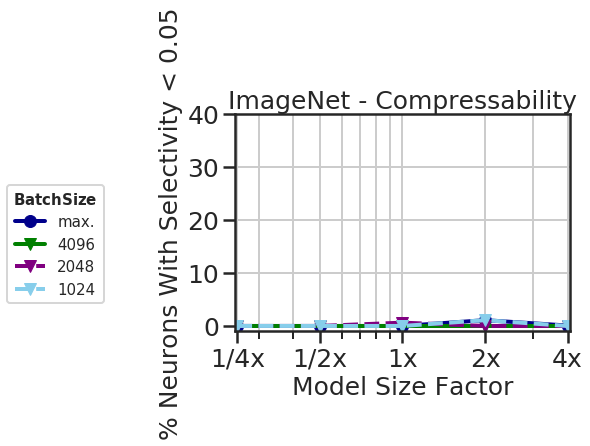

In [14]:
#ImageNet

sys.path.append('../')
sys.path.append('../ImageNet/')
from ImageNet.experiments import experiments

opts = experiments.get_experiments('','')
yticks = [0, 10, 20, 30, 40]
curves = 4
curve_labels = ['max.',  '4096', '2048', '1024']
curve_colors = ['darkblue', 'green', 'purple', 'skyblue']
curve_styles = ['-', '-', '--', '--', '--', '-']
marker_styles = ['o', 'v', 'v', 'v']
sizes = 5
size_factors = np.array([0.25, 0.5, 1, 2, 4])
size_idx_map = {0.25: 0, 0.5: 1, 1: 2, 2: 3, 4: 4}
size_labels = ['1/4x', '1/2x', '1x', '2x', '4x']
crosses = 1

results = np.zeros((curves, sizes))

# both are indexed [nn_type][size_factor]

for ID in range(5):

    #print('Processing ID:', ID)
    opt = opts[ID]

    curve_idx = 0  # unregularized

    size_idx = size_idx_map[opt.dnn.factor]
    
    csv_file = opt.csv_dir + opt.name + '_redundancy.csv'
    df = pd.read_csv(csv_file)
    similiarity_ave = np.array([df[df['evaluation_set'] == 'validation'][df['layer'] == 'all']
                            ['nonselective'].iloc[0] for i in range(crosses)])
    results[curve_idx, size_idx] = np.mean(similiarity_ave)
    

batch_plot = [4096, 2048, 1024]
for ID in range(13):

    #print('Processing ID:', ID)
    opt = opts[ID]

    size_idx = size_idx_map[opt.dnn.factor]
    batch_idx = np.where(np.asarray(batch_plot) == opt.hyper.batch_size)[0]
    if len(batch_idx):
        csv_file = opt.csv_dir + opt.name + '_redundancy.csv'        
        df = pd.read_csv(csv_file)
        similiarity_ave = np.array([df[df['evaluation_set'] == 'validation'][df['layer'] == 'all']
                                ['nonselective'].iloc[0] for i in range(crosses)])
        results[int(batch_idx)+1, size_idx] = np.mean(similiarity_ave)
        
results *= 100

        
print_nonselectivity(r'ImageNet - Compressability', results, marker_styles, 
               curve_colors, curve_styles, curve_labels, yticks, r"$\bf{Batch} \bf{Size}$", 0.1)


